In [2]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Project objective: Demand forecast (unit sales) for potential new products for "The Brand"

**Notebook objective:**
- Split out test
- Target and feature EDA

**Key findings:**
- 

In [147]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

from src.utils.constants import TARGET

In [57]:
pd.options.display.float_format = "{:.4f}".format
pd.set_option("display.max_columns", 99)
pd.set_option("display.max_rows", 99)
pd.set_option("display.max_colwidth", 199)

In [12]:
base_dir = Path("/Users/igari/OneDrive/Documents/thebrand")
data = base_dir / "data"

# Reading in cleaned data

In [38]:
input_path = data / "01_raw" / "src.csv"
df = pd.read_parquet(input_path)
df.shape

(382, 11)

In [58]:
df.describe()

,single,"married, no kids","not married, no kids","married, with kids","not married, with kids",single parent,other,total,avg_woz,woz_per_msq
count,382.0000,382.0000,382.0000,382.0000,382.0000,382.0000,382.0000,382.0000,382.0000,382.0000
mean,616.3481,106.4686,133.1230,133.9241,55.4791,104.0759,16.2147,1165.6335,261200.6094,3125.3010
std,413.8062,75.0495,102.0847,121.4060,41.1388,88.1333,13.5889,711.0565,133747.5000,862.3971
min,11.0000,0.0000,3.0000,0.0000,0.0000,1.0000,0.0000,51.0000,46287.0000,1427.0000
25%,277.2500,53.0000,59.0000,51.0000,25.0000,36.0000,6.0000,599.2500,177105.5000,2317.5000
50%,554.0000,94.0000,104.0000,101.5000,50.0000,87.0000,13.0000,1075.5000,230057.5000,3188.0000
75%,875.0000,141.7500,182.0000,183.2500,75.0000,152.0000,23.0000,1620.2500,296509.0000,3863.0000
max,2130.0000,366.0000,617.0000,812.0000,295.0000,612.0000,89.0000,3419.0000,1295077.0000,4620.0000


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 382 entries, 0 to 461
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   area                    382 non-null    object 
 1   single                  382 non-null    float32
 2   married, no kids        382 non-null    float32
 3   not married, no kids    382 non-null    float32
 4   married, with kids      382 non-null    float32
 5   not married, with kids  382 non-null    float32
 6   single parent           382 non-null    float32
 7   other                   382 non-null    float32
 8   total                   382 non-null    float32
 9   avg_woz                 382 non-null    float32
 10  woz_per_msq             382 non-null    float32
dtypes: float32(10), object(1)
memory usage: 20.9+ KB


# Keeping test data aside 

In [77]:
train, test = train_test_split(
    df, test_size=0.1, random_state=None, shuffle=12, stratify=None
)
print(train.shape, test.shape)

(343, 11) (39, 11)


<AxesSubplot:xlabel='avg_woz', ylabel='Count'>

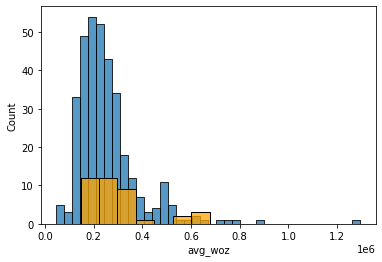

In [78]:
# Comparing the distribution of areas house counts in train and test dataframes
sns.histplot(data=train, x=TARGET)
sns.histplot(data=test, x=TARGET, color="orange")

(343, 11) (39, 11)


<AxesSubplot:xlabel='avg_woz', ylabel='Count'>

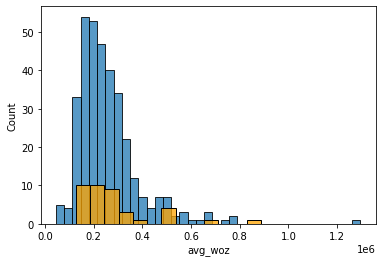

In [94]:
# This test set misses extreme values, which we should test for. So let us stratify the split based on target.
total_bin = pd.cut(df[TARGET], bins=[0, 500000, 1300000])
train, test = train_test_split(df, test_size=0.1, random_state=None, stratify=total_bin)

print(train.shape, test.shape)

# Comparing the distribution of areas house counts in train and test dataframes
sns.histplot(data=train, x=TARGET)
sns.histplot(data=test, x=TARGET, color="orange")

In [95]:
output_test_path = data / "01_raw" / "test_raw.csv"
output_train_path = data / "01_raw" / "train_raw.csv"
test.to_parquet(output_test_path, index=None)

train.to_parquet(output_train_path, index=None)

In [ ]:
# Choosing the target feature out of 3 KPIs

In [ ]:
sns.pairplot(df)

# Exploring the target 

<AxesSubplot:xlabel='avg_woz'>

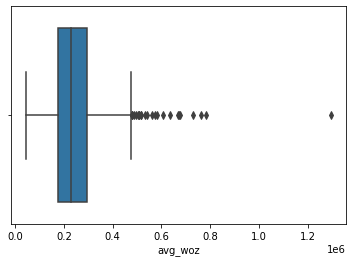

In [96]:
sns.boxplot(data=train, x=TARGET)

<AxesSubplot:xlabel='avg_woz', ylabel='Count'>

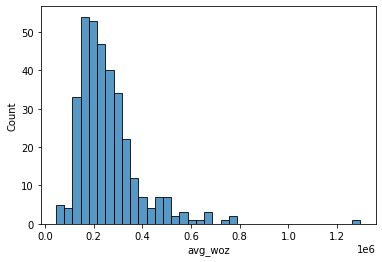

In [97]:
sns.histplot(data=train, x=TARGET)

<AxesSubplot:xlabel='avg_woz', ylabel='Count'>

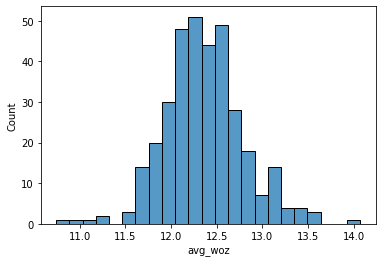

In [115]:
sns.histplot(data=train, x=np.log(train[TARGET]))
# sns.boxplot(data=train, x=np.log(train[TARGET]))

In [99]:
train[train[TARGET] > 450000]["area"].count()

28

In [100]:
train[train[TARGET] > 1000000]["area"]

253    K49a Diepenbrockbuurt
Name: area, dtype: object

In [70]:
train.loc[253, :]
# Diepenbrockbuurt is the outlier in this data. It has avg woz value of over 1.2 MM and has 331 houses (much lower than avg of 972)

area                      K49a Diepenbrockbuurt
single                                    121.0
married, no kids                           57.0
not married, no kids                       19.0
married, with kids                         92.0
not married, with kids                     18.0
single parent                              17.0
other                                       7.0
total                                     331.0
avg_woz                               1295077.0
woz_per_msq                              4139.0
Name: 253, dtype: object

These outliers can cause issues but this depends on the algorithm. We will leave this as a possible improvement for later.

# Checking the feature distribution, significance and correlations

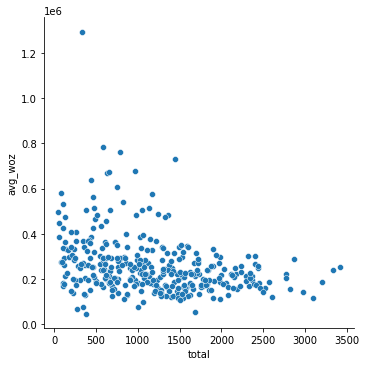

In [117]:
# Relationship between total house counts per area and target?
sns.relplot(x="total", y=TARGET, data=train)

There is not a real linear relationship that is visible. However, one thing is strikingly clear that beyond 1500 houses per area, the avg woz value is lower than where the houses are lesser.

<AxesSubplot:>

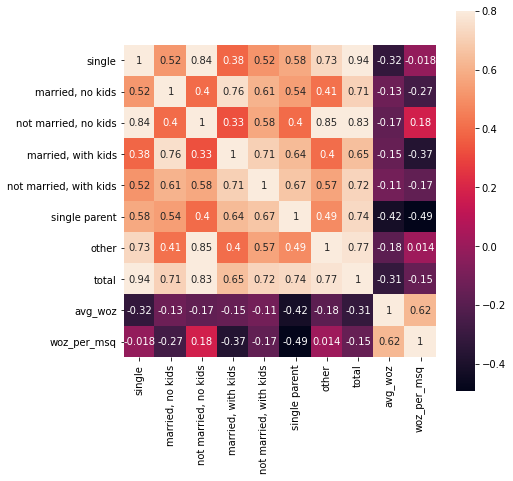

In [123]:
# correlation matrix
corrmat = train.corr()
plt.figure(figsize=(7, 7))
sns.heatmap(corrmat, vmax=0.8, square=True, annot=True)

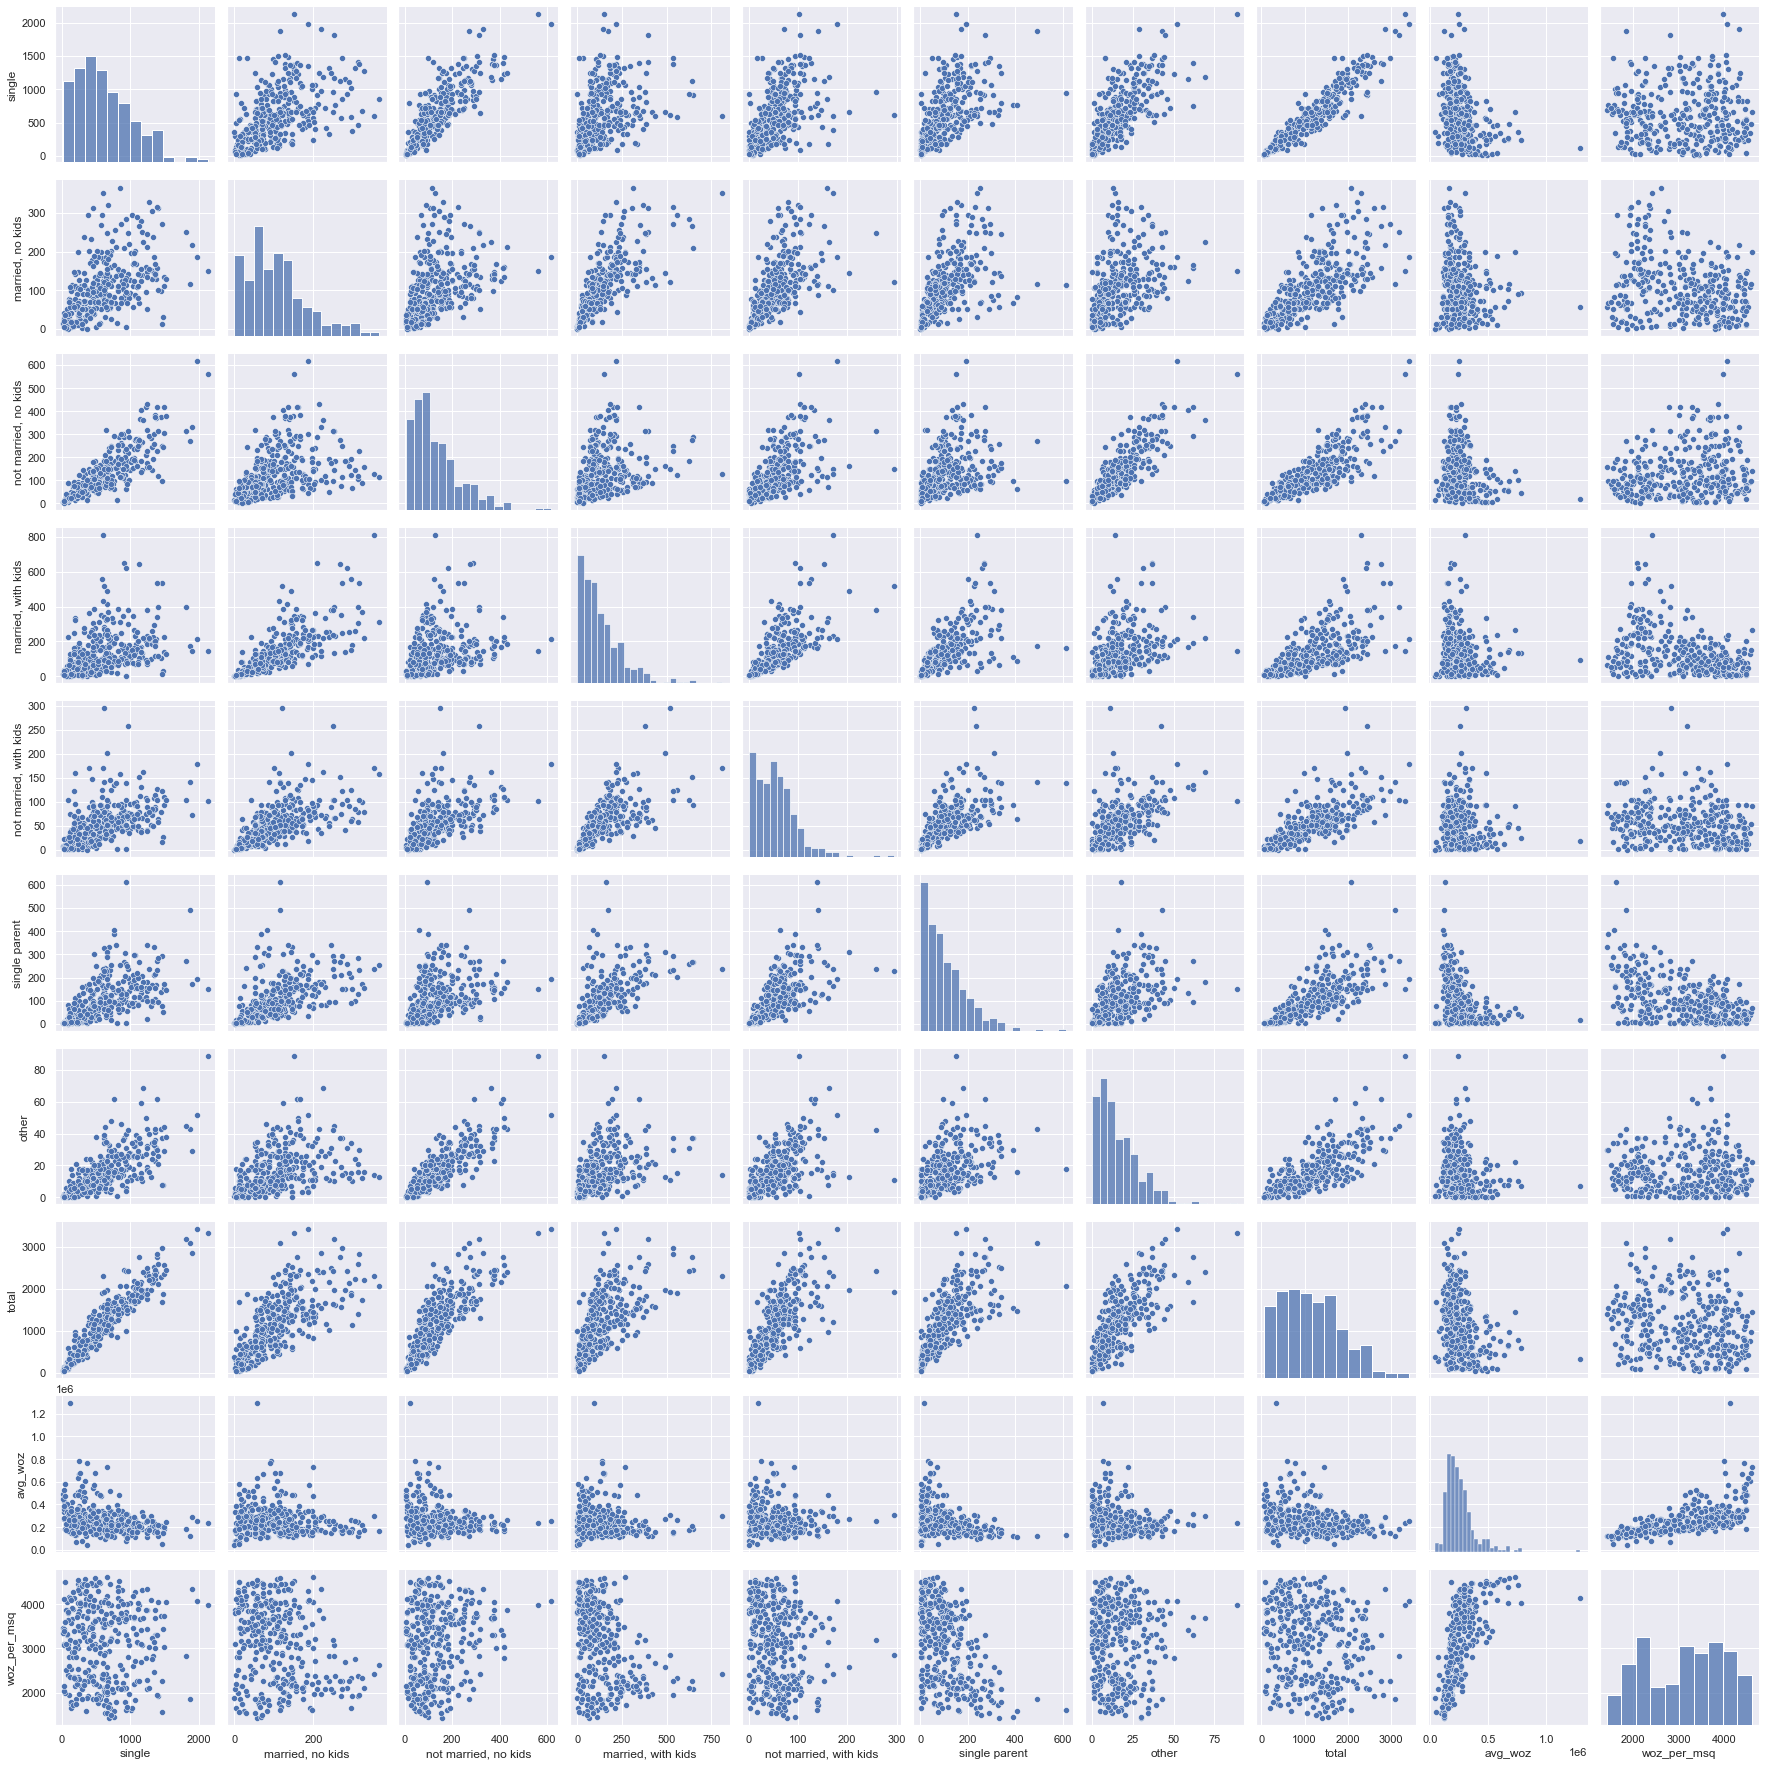

In [125]:
# sns.pairplot(train, height=2.5)
# plt.show()

Linear correlations of features with the target are so bad. Multi-collinearity also exists amongst features. Linear model would not be good for this problem